## 📋 Datasheet for MIT-BIH Arrhythmia Dataset
**Sumber Dataset**: [MIT-BIH Arrhythmia Database di PhysioNet](https://www.physionet.org/content/mitdb/1.0.0/)  
**Lisensi**: Open Access (ODC Open Database License)  

### **Deskripsi Dataset**
- **Tujuan**: Klasifikasi detak jantung abnormal dari sinyal ECG.
- **Karakteristik Sinyal**:
  - Frekuensi sampling: 360 Hz
  - Resolusi: 11-bit (mencakup rentang ±5 mV)
  - Durasi per sampel: 30 detik
- **Label Kelas**:
  - `0`: Normal (N)
  - `1`: Supraventricular ectopic beat (S)
  - `2`: Ventricular ectopic beat (V)
  - `3`: Fusion beat (F)
  - `4`: Unknown beat (Q)

### **Statistik Dataset**
| Kelas       | Jumlah Sampel (Asli) | Keterangan                          |
|-------------|----------------------|-------------------------------------|
| Normal      | 90,000+              | Detak jantung normal                |
| Unknown     | ~2,800               | Gangguan non-spesifik               |
| Ventricular | ~3,200               | Gangguan ventrikel                  |
| Fusion      | ~800                 | Kombinasi normal-abnormal           |
| Supraventricular | ~2,500         | Gangguan atrium                     |

### **Etika dan Bias**
- Data diambil dari 47 pasien dewasa (23 pria, 22 wanita, 2 tidak diketahui).
- **Bias Potensial**: Distribusi kelas tidak seimbang (kelas minoritas mungkin kurang terwakili).

In [21]:
## 🚀 Persiapan Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [22]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/ECG_Data"

train_path = '/content/drive/MyDrive/ECG_Data/mitbih_train.csv'
test_path = '/content/drive/MyDrive/ECG_Data/mitbih_test.csv'

test = pd.read_csv(test_path, header=None)
train = pd.read_csv(train_path, header=None)

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)
print("\n5 sampel pertama data training:")
print(train.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mitbih_test.csv  mitbih_train.csv
Train data shape: (87554, 188)
Test data shape: (21892, 188)

5 sampel pertama data training:
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0 

## 📊 Visualisasi Distribusi Kelas

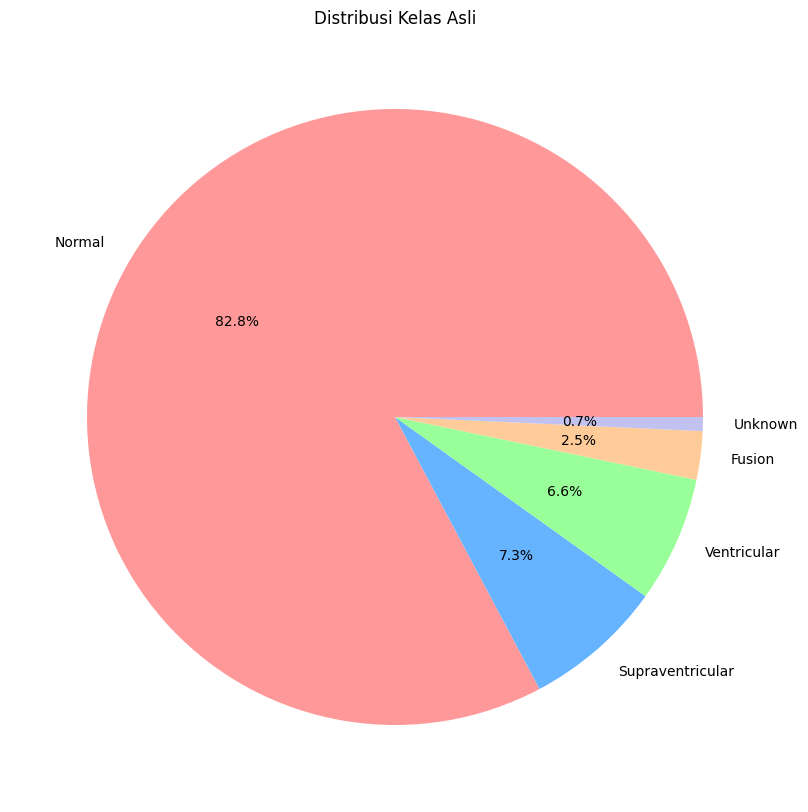

In [23]:
plt.figure(figsize=(10,10))
plt.pie(train[187].value_counts(),
        labels=['Normal','Supraventricular','Ventricular','Fusion','Unknown'],
        autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Distribusi Kelas Asli')
plt.show()

## ⚖️ Penyeimbangan Kelas

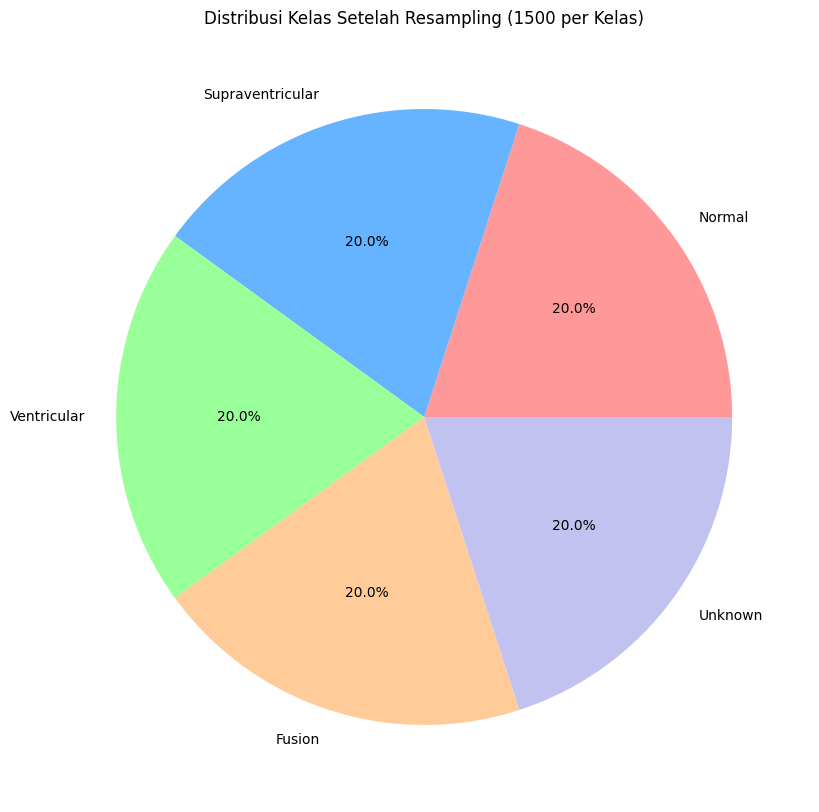

In [45]:
from sklearn.utils import resample

# Increase sample size for better training
sample_size = 1500
dfs = [train[train[187]==i].sample(sample_size, replace=True, random_state=42) for i in range(5)]
balanced_train = pd.concat(dfs)

# Visualisasi distribusi baru
plt.figure(figsize=(10,10))
plt.pie(balanced_train[187].value_counts(),
        labels=['Normal','Supraventricular','Ventricular','Fusion','Unknown'],
        autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title(f'Distribusi Kelas Setelah Resampling ({sample_size} per Kelas)')
plt.show()

## ⚙️ Praproses Data

In [46]:
# Pisahkan fitur dan label
X_train = balanced_train.iloc[:, :-1].values
y_train = balanced_train.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Konversi label untuk ANN
y_train_ann = to_categorical(y_train)
y_test_ann = to_categorical(y_test)

## 🤖 Implementasi Model & Evaluasi

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

def evaluate_model(model, X_test, y_test, model_name):
    # Get predictions
    if model_name == 'ANN':
        y_pred_prob = model.predict(X_test)
        y_pred_class = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
    else:
        y_pred_class = model.predict(X_test)
        y_true = y_test
        y_pred_prob = model.predict_proba(X_test)

    # Accuracy, Precision, Recall, F1-score
    print(f"\n🔍 {model_name} Classification Report:")
    print(classification_report(y_true, y_pred_class))

    # Confusion Matrix
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_true, y_pred_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal','Supraventricular','Ventricular','Fusion','Unknown'],
                yticklabels=['Normal','Supraventricular','Ventricular','Fusion','Unknown'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC Curve and AUC
    plt.figure(figsize=(10, 8))

    # For multiclass ROC curves, we use one-vs-rest approach
    from sklearn.preprocessing import label_binarize
    classes = list(range(5))  # 5 classes (0-4)

    if model_name == 'ANN':
        # For ANN, we already have the probabilities
        y_test_bin = label_binarize(y_true, classes=classes)
        y_score = y_pred_prob
    else:
        # For other models
        y_test_bin = label_binarize(y_true, classes=classes)
        y_score = y_pred_prob

    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy_score(y_true, y_pred_class),
        'precision': precision_score(y_true, y_pred_class, average='weighted'),
        'recall': recall_score(y_true, y_pred_class, average='weighted'),
        'f1': f1_score(y_true, y_pred_class, average='weighted'),
        'auc': np.mean(list(roc_auc.values()))
    }

###1. SVM


🔍 SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     18118
         1.0       0.37      0.71      0.48       556
         2.0       0.66      0.87      0.75      1448
         3.0       0.11      0.91      0.19       162
         4.0       0.83      0.94      0.88      1608

    accuracy                           0.85     21892
   macro avg       0.59      0.86      0.64     21892
weighted avg       0.93      0.85      0.88     21892



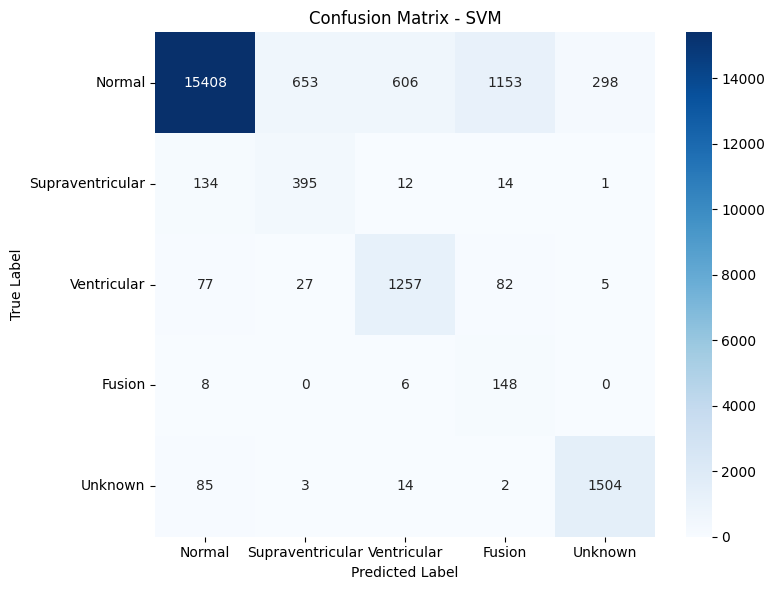

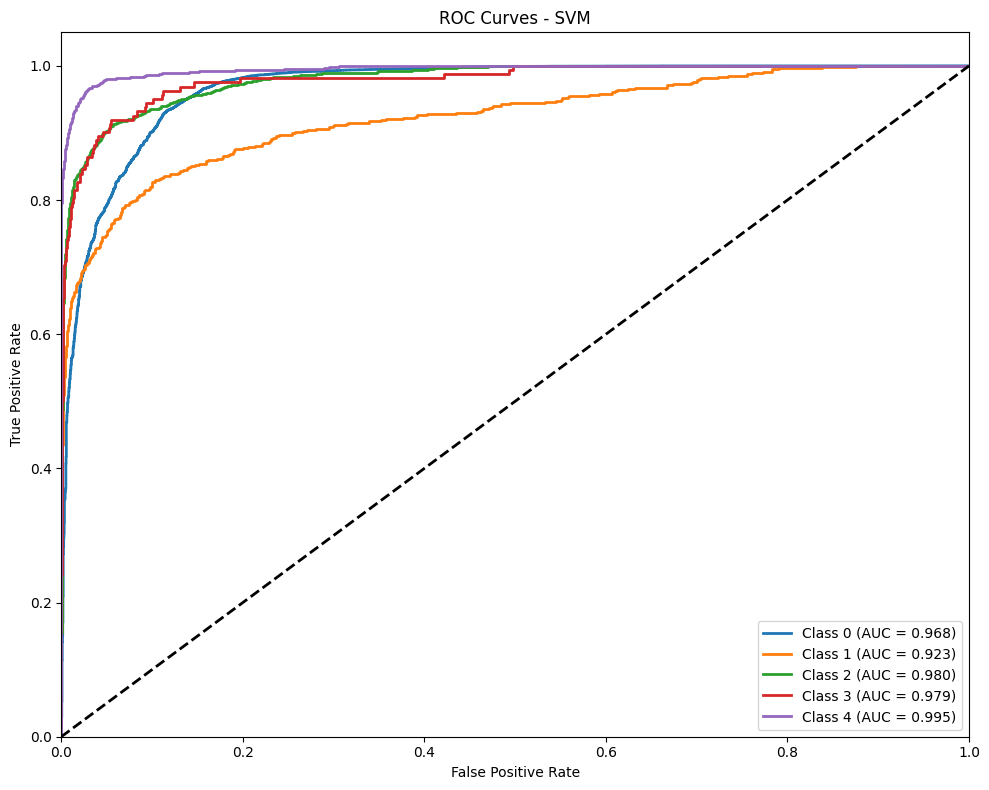

{'accuracy': 0.8547414580668737,
 'precision': 0.9266598482940378,
 'recall': 0.8547414580668737,
 'f1': 0.8819760968096005,
 'auc': np.float64(0.9689911412403246)}

In [48]:
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)
evaluate_model(svm_model, X_test_scaled, y_test, 'SVM')

### 2. k-Nearest Neighbors (k-NN)


🔍 k-NN Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.88     18118
         1.0       0.21      0.78      0.33       556
         2.0       0.59      0.85      0.70      1448
         3.0       0.12      0.91      0.21       162
         4.0       0.85      0.95      0.90      1608

    accuracy                           0.81     21892
   macro avg       0.55      0.86      0.60     21892
weighted avg       0.92      0.81      0.85     21892



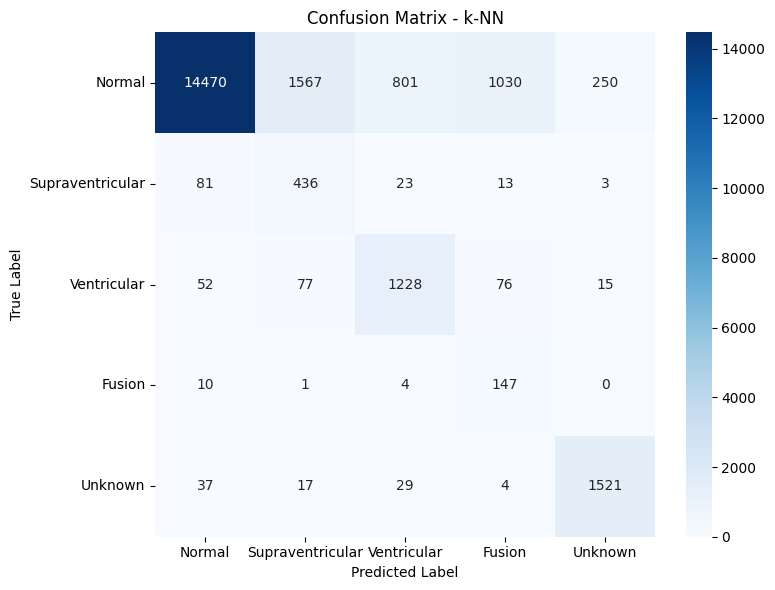

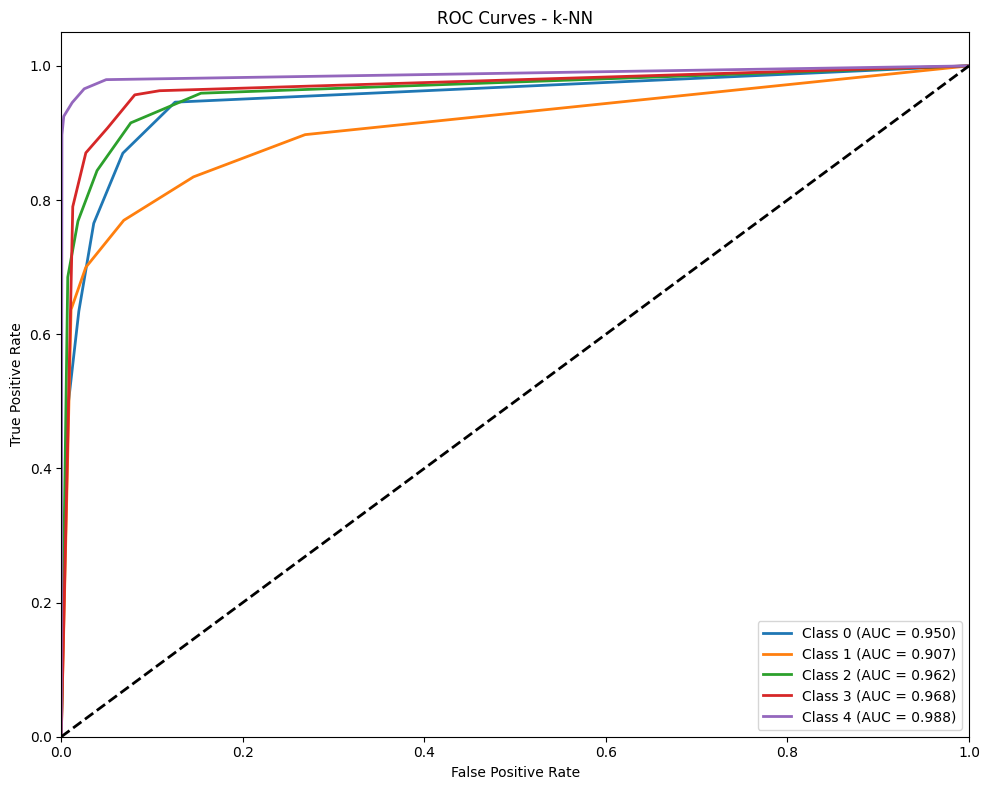

{'accuracy': 0.8131737621048785,
 'precision': 0.9249784681332317,
 'recall': 0.8131737621048785,
 'f1': 0.8525452478033482,
 'auc': np.float64(0.9547382093759682)}

In [49]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
evaluate_model(knn_model, X_test_scaled, y_test, 'k-NN')

### 3. Random Forest (RF)


🔍 Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     18118
         1.0       0.41      0.81      0.55       556
         2.0       0.73      0.92      0.81      1448
         3.0       0.27      0.88      0.41       162
         4.0       0.92      0.96      0.94      1608

    accuracy                           0.91     21892
   macro avg       0.66      0.90      0.73     21892
weighted avg       0.95      0.91      0.93     21892



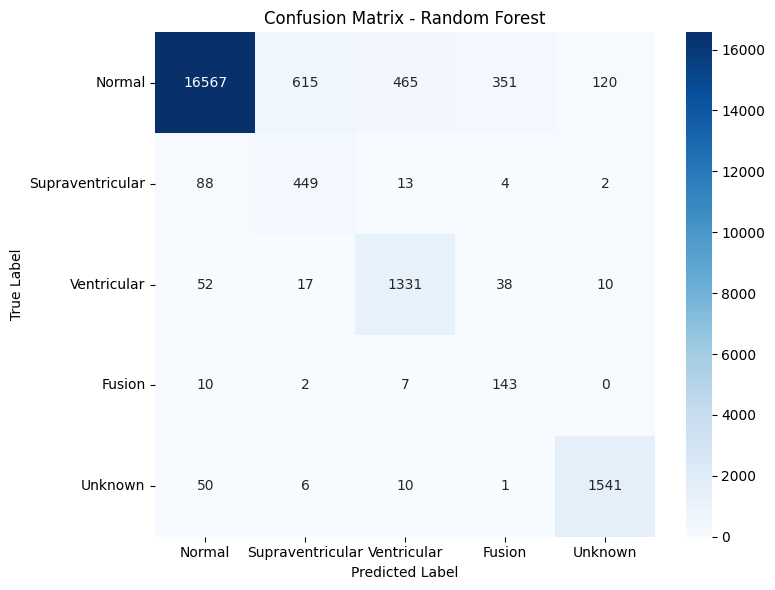

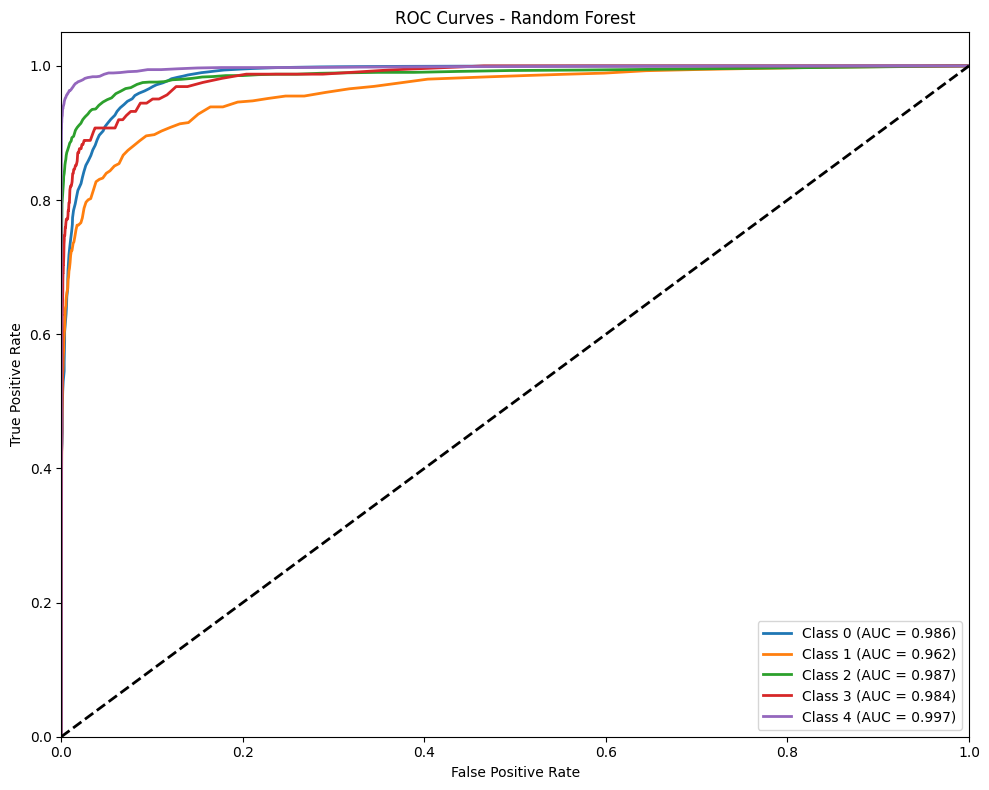

{'accuracy': 0.9149917778183811,
 'precision': 0.9460471667354936,
 'recall': 0.9149917778183811,
 'f1': 0.925735271196193,
 'auc': np.float64(0.9832190900249964)}

In [50]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')

### 4. Artificial Neural Network (ANN)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

🔍 ANN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     18118
           1       0.38      0.76      0.51       556
           2       0.70      0.92      0.79      1448
           3       0.25      0.91      0.39       162
           4       0.93      0.96      0.94      1608

    accuracy                           0.91     21892
   macro avg       0.65      0.89      0.72     21892
weighted avg       0.94      0.91      0.92     21892



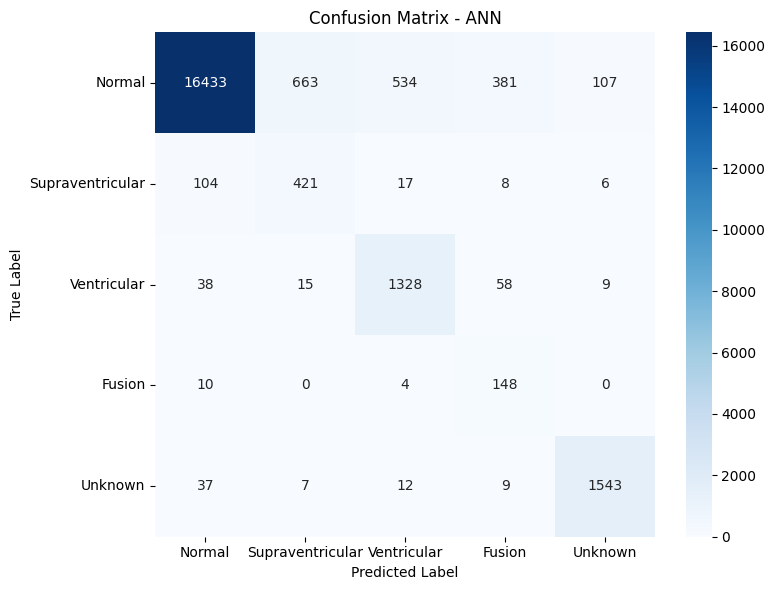

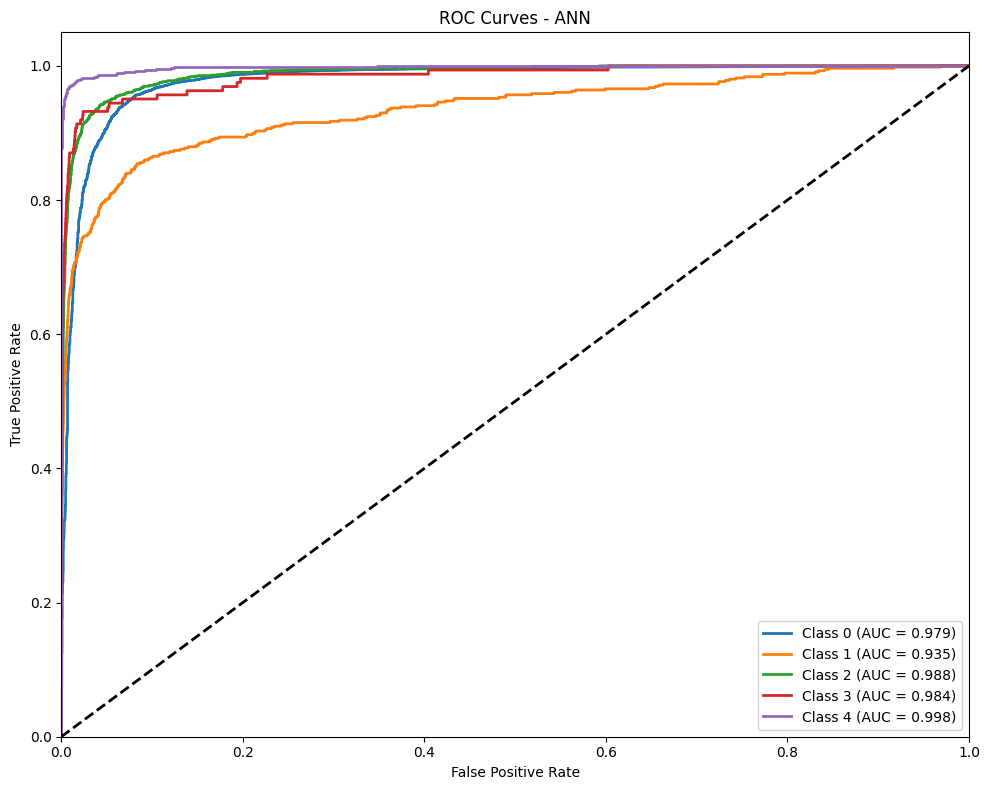

{'accuracy': 0.9077745295084962,
 'precision': 0.944100577404154,
 'recall': 0.9077745295084962,
 'f1': 0.9204955738451421,
 'auc': np.float64(0.9767233700206976)}

In [51]:
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

ann_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = ann_model.fit(X_train_scaled, y_train_ann,
                      epochs=50,
                      batch_size=128,
                      validation_data=(X_test_scaled, y_test_ann),
                      verbose=0)

evaluate_model(ann_model, X_test_scaled, y_test_ann, 'ANN')

### Compare Model

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

📊 Performance Comparison:
               accuracy  precision    recall        f1
SVM            0.854741   0.926660  0.854741  0.881976
k-NN           0.813174   0.924978  0.813174  0.852545
Random Forest  0.914992   0.946047  0.914992  0.925735
ANN            0.907775   0.944101  0.907775  0.920496


<Figure size 1200x800 with 0 Axes>

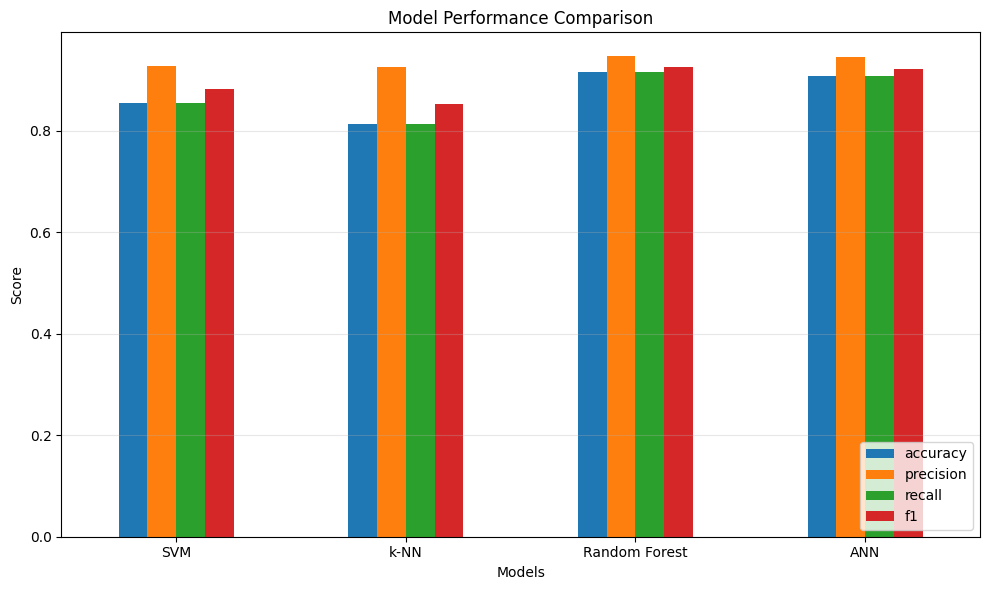


🏆 Best Model based on F1-Score: Random Forest with F1-Score of 0.9257


In [52]:
results = {}

# For SVM model metrics
svm_pred = svm_model.predict(X_test_scaled)
results['SVM'] = {
    'accuracy': accuracy_score(y_test, svm_pred),
    'precision': precision_score(y_test, svm_pred, average='weighted'),
    'recall': recall_score(y_test, svm_pred, average='weighted'),
    'f1': f1_score(y_test, svm_pred, average='weighted')
}

# For k-NN model metrics
knn_pred = knn_model.predict(X_test_scaled)
results['k-NN'] = {
    'accuracy': accuracy_score(y_test, knn_pred),
    'precision': precision_score(y_test, knn_pred, average='weighted'),
    'recall': recall_score(y_test, knn_pred, average='weighted'),
    'f1': f1_score(y_test, knn_pred, average='weighted')
}

# For Random Forest model metrics
rf_pred = rf_model.predict(X_test_scaled)
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred, average='weighted'),
    'recall': recall_score(y_test, rf_pred, average='weighted'),
    'f1': f1_score(y_test, rf_pred, average='weighted')
}

# For ANN model metrics
ann_pred = np.argmax(ann_model.predict(X_test_scaled), axis=1)
ann_true = np.argmax(y_test_ann, axis=1)
results['ANN'] = {
    'accuracy': accuracy_score(ann_true, ann_pred),
    'precision': precision_score(ann_true, ann_pred, average='weighted'),
    'recall': recall_score(ann_true, ann_pred, average='weighted'),
    'f1': f1_score(ann_true, ann_pred, average='weighted')
}

# Compare model performances
metrics_df = pd.DataFrame(results).T
print("\n📊 Performance Comparison:")
print(metrics_df)

# Visualize comparison
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Find the best model
best_model = metrics_df['f1'].idxmax()
print(f"\n🏆 Best Model based on F1-Score: {best_model} with F1-Score of {metrics_df.loc[best_model]['f1']:.4f}")